In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import models
from glob import glob
import cv2
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation, RotationSpline
import open3d as o3d
import numpy as np

In [8]:
def FileLoader(preprocess=None):
    def innner(func):
        class Loader():
            def __init__(self, files):
                self.files = files
            def __getitem__(self, idx):
                if preprocess:
                    return preprocess(func(self.files[idx]))
                return func(self.files[idx])
            def __len__(self):
                return len(self.files)        
        def wrapper_func(glob_folder):
            files = sorted(glob(glob_folder))
            return Loader(files)
        return wrapper_func
    return innner

In [9]:
@FileLoader(preprocess = lambda x : cv2.cvtColor(x, cv2.COLOR_BGR2GRAY))
def RGBImageLoader(x):
    return cv2.imread(x)

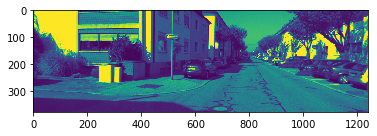

In [10]:
rgbloader = RGBImageLoader('/media/kbuyukburc/DATASET/kitti-odo/data_odometry_color/dataset/sequences/00/image_2/*')
len(rgbloader)
plt.imshow(rgbloader[100][..., ::-1])

In [166]:
def tensorifyIMG(img : np.ndarray):
    img = np.transpose(img, axes=[2,0,1]) / 255    
    return img

def randomTransformation(max_rot = 5, max_tra = 0.5):
    rotation_rnd = (np.random.random(3) - 0.5) * 2 * max_rot * np.pi / 180
    translation_rnd = (np.random.random(3) - 0.5) * 2 * max_tra
    extrinsic = np.eye(4)
    extrinsic[:3,:3] = Rotation.from_rotvec(rotation_rnd).as_matrix()
    extrinsic[:3, 3] = translation_rnd
    return extrinsic

class FusionDataset(Dataset):
    def __init__(self, camera_dataset, 
                lidar_dataset, 
                intrinsic,
                distortion,
                extrinsic,
                tensor_shape = (512, 512)                
                ):
        super().__init__()
        self.camera = camera_dataset
        self.lidar = lidar_dataset
        self.intrinsic = intrinsic
        self.distortion = distortion
        self.extrinsic = extrinsic # Lidar To Camera        
        self.tensor_shape = tensor_shape
        assert len(self.camera) == len(self.lidar), "Dataset length are not matching."

    def __len__(self):
        return len(self.camera)

    def projectDepth(self, pointcloud):
        points_3d = np.asarray(pointcloud.points)
        zero_vec = np.array([0,0,0], dtype=np.float32)
        points_img, _ =  cv2.projectPoints(points_3d, zero_vec, zero_vec, 
                    self.intrinsic, self.distortion)
        
        points_img = points_img[:, 0, :]
        points_img_flag = (points_img[:, 1] > 0) & (points_img[:, 1] < self.tensor_shape[0]) & \
            (points_img[:, 0] > 0) & (points_img[:, 0] < self.tensor_shape[1]) & \
                (points_3d[:, 2] > 0)
        points_3d_flaged = points_3d[points_img_flag]
        points_img_flaged = points_img[points_img_flag]
        points_3d_norm = np.linalg.norm(points_3d_flaged, axis=1)[::-1]
        
        ind = np.argsort(points_3d_norm)[::-1]
        points_img_sorted = points_img_flaged[ind]
        points_img_sorted = points_img_sorted.astype(int)
        
        depth = np.zeros((1, *self.tensor_shape), dtype=np.float32)
        depth[0, points_img_sorted[:, 1], points_img_sorted[:, 0]] = points_3d_flaged[:, 2]#points_3d_norm
        return depth

    def __getitem__(self, index):
        img = self.camera[index]
        img_resize = cv2.resize(img, self.tensor_shape)
        h, w = img.shape[:2]
        intrinsic = self.intrinsic.copy()
        intrinsic[0] *= (self.tensor_shape[0]/w)
        intrinsic[1] *= (self.tensor_shape[1]/h)
        
        pointcloud : o3d.geometry.PointCloud = self.lidar[index]
        pointcloud.transform(self.extrinsic)
        depth_gt = self.projectDepth(pointcloud)
        miss_calibration = randomTransformation()
        pointcloud.transform(miss_calibration)
        depth = self.projectDepth(pointcloud)
        return {'img' : tensorifyIMG(img_resize),
                'depth': depth,
                'depth_gt': depth_gt,
                'extrinsic': miss_calibration.astype(np.float32),
                'intrinsic': self.intrinsic.astype(np.float32)
            }

In [167]:
@FileLoader()
def RGBImageLoader(x):
    return cv2.imread(x)
cam2 = RGBImageLoader('/media/kbuyukburc/DATASET/kitti-odo/data_odometry_color/dataset/sequences/00/image_2/*')

@FileLoader()
def PCDLoader(x):
    bin = np.fromfile(x, dtype=np.float32).reshape(-1, 4)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(bin[:, :3])
    pcd.colors = o3d.utility.Vector3dVector(np.c_[bin[:, 3], bin[:, 3], bin[:, 3]])
    return pcd
lidar1 = PCDLoader('/media/kbuyukburc/DATASET/kitti-odo/data_odometry_velodyne/dataset/sequences/00/velodyne/*')

In [168]:
class DatasetMerger:
    def __init__(self, *args):
        self.dataset_list = [*args]
        self.datset_length = [len(dataset) for dataset in self.dataset_list]
        self.dataset_edge = [0]
        for dataset in self.dataset_list:
            self.dataset_edge.append(len(dataset)+self.dataset_edge[-1])
        self.length = self.dataset_edge[-1]
    
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        assert idx >= 0 and idx < len(self), "Out of range"
        for id, dataset in enumerate(self.dataset_list):
            if self.dataset_edge[id+1] > idx >= self.dataset_edge[id]:
                return dataset[idx-self.dataset_edge[id]]
        raise('Something went wrong!')

class DatasetSequencer:
    def __init__(self, dataset, sequence_length = 10):
        self.dataset = dataset
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.dataset) // self.sequence_length

    def __getitem__(self, idx):
        assert idx >= 0 and idx < len(self), "Out of range"
        index = idx * self.sequence_length
        batch_data = self.dataset[index]
        if isinstance(batch_data, np.ndarray):
            data_shape = batch_data.shape
            batch_data = batch_data[None, ...]
            for num in range(1, self.sequence_length):
                data =  self.dataset[index+num]
                assert data_shape == data.shape, "Data Shape not matching"
                batch_data = np.append(batch_data, data[None, ...], axis=0)
        elif isinstance(batch_data, dict):
            data_shape = {key : data.shape for key, data in batch_data.items()}
            batch_data = {key : data[None, ...] for key, data in batch_data.items()}
            for num in range(1, self.sequence_length):
                data =  self.dataset[index+num]
                for key in batch_data.keys():
                    assert data_shape[key] == data[key].shape, "Data Shape not matching"
                    batch_data[key] = np.append(batch_data[key], data[key][None, ...], axis=0)
        else:
            raise('Hmmm! we werent expecting this case =/.')


        return batch_data


In [169]:
mergedset = DatasetMerger(cam2, lidar1)
print(len(cam2), len(lidar1), len(mergedset))
print(type(mergedset[0]), type(mergedset[9081]))

4541 4541 9082
<class 'numpy.ndarray'> <class 'open3d.cuda.pybind.geometry.PointCloud'>


In [170]:
sqset = DatasetSequencer(dataset=cam2, sequence_length=10)
print(len(sqset))
print(sqset[0].shape)
print(sqset[453].shape)

454
(10, 376, 1241, 3)
(10, 376, 1241, 3)


In [171]:
from os import path
def load_kitti_calib(filename):
    filedata = {}
    data = {}
    with open(filename) as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                filedata[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass
    # Create 3x4 projection matrices
    P_rect_00 = np.reshape(filedata['P0'], (3, 4))
    P_rect_10 = np.reshape(filedata['P1'], (3, 4))
    P_rect_20 = np.reshape(filedata['P2'], (3, 4))
    P_rect_30 = np.reshape(filedata['P3'], (3, 4))

    data['P_rect_00'] = P_rect_00
    data['P_rect_10'] = P_rect_10
    data['P_rect_20'] = P_rect_20
    data['P_rect_30'] = P_rect_30

    # Compute the rectified extrinsics from cam0 to camN
    T1 = np.eye(4)
    T1[0, 3] = P_rect_10[0, 3] / P_rect_10[0, 0]
    T2 = np.eye(4)
    T2[0, 3] = P_rect_20[0, 3] / P_rect_20[0, 0]
    T3 = np.eye(4)
    T3[0, 3] = P_rect_30[0, 3] / P_rect_30[0, 0]

    # Compute the velodyne to rectified camera coordinate transforms
    data['T_cam0_velo'] = np.reshape(filedata['Tr'], (3, 4))
    data['T_cam0_velo'] = np.vstack([data['T_cam0_velo'], [0, 0, 0, 1]])
    data['T_cam1_velo'] = T1.dot(data['T_cam0_velo'])
    data['T_cam2_velo'] = T2.dot(data['T_cam0_velo'])
    data['T_cam3_velo'] = T3.dot(data['T_cam0_velo'])

    # Compute the camera intrinsics
    data['K_cam0'] = P_rect_00[0:3, 0:3]
    data['K_cam1'] = P_rect_10[0:3, 0:3]
    data['K_cam2'] = P_rect_20[0:3, 0:3]
    data['K_cam3'] = P_rect_30[0:3, 0:3]

    # Compute the stereo baselines in meters by projecting the origin of
    # each camera frame into the velodyne frame and computing the distances
    # between them
    p_cam = np.array([0, 0, 0, 1])
    p_velo0 = np.linalg.inv(data['T_cam0_velo']).dot(p_cam)
    p_velo1 = np.linalg.inv(data['T_cam1_velo']).dot(p_cam)
    p_velo2 = np.linalg.inv(data['T_cam2_velo']).dot(p_cam)
    p_velo3 = np.linalg.inv(data['T_cam3_velo']).dot(p_cam)

    data['b_gray'] = np.linalg.norm(p_velo1 - p_velo0)  # gray baseline
    data['b_rgb'] = np.linalg.norm(p_velo3 - p_velo2)   # rgb baseline

    return data        

In [172]:
from os import path
root_folder = '/media/kbuyukburc/DATASET/kitti-odo/'
class KITTIDatset(DatasetMerger):
    def __init__(self, root_folder : str, sequence : str):        
        self.cam2 = RGBImageLoader(path.join(root_folder, f'data_odometry_color/dataset/sequences/{sequence}/image_2/*'))
        self.cam3 = RGBImageLoader(path.join(root_folder, f'data_odometry_color/dataset/sequences/{sequence}/image_3/*'))
        self.lidar1 = PCDLoader(path.join(root_folder, f'data_odometry_velodyne/dataset/sequences/{sequence}/velodyne/*'))
        self.calib = load_kitti_calib(path.join(root_folder, f'data_odometry_calib/dataset/sequences/{sequence}/calib.txt'))
        distortion = np.array([0,0,0,0,0.])
        self.dataset_1 = DatasetSequencer(FusionDataset(camera_dataset=self.cam2, lidar_dataset=self.lidar1,
              intrinsic=self.calib['K_cam2'], distortion=distortion,
              extrinsic=self.calib['T_cam2_velo']
            ), sequence_length=10)
        self.dataset_2 = DatasetSequencer(FusionDataset(camera_dataset=self.cam3, lidar_dataset=self.lidar1,
              intrinsic=self.calib['K_cam3'], distortion=distortion,
              extrinsic=self.calib['T_cam3_velo']
            ), sequence_length=10)
        DatasetMerger.__init__(self, self.dataset_1, self.dataset_2)
      
      


In [173]:
kittiset = KITTIDatset(root_folder, '00')
kittiset[0]['img'].shape

(10, 3, 512, 512)

In [174]:
intrinsic = np.array([[718.856 ,   0.    , 607.1928],
       [  0.    , 718.856 , 185.2157],
       [  0.    ,   0.    ,   1.    ]])
distortion = np.array([0,0,0,0,0.])
rotvec_gt = np.asarray([ 1.20875812, -1.21797831, 1.19949], dtype="float32")  
tvec_gt = np.asarray([0.05114661, -0.05403985, -0.29219686], dtype="float32")
extrinsic = np.eye(4)
extrinsic[:3, :3] = Rotation.from_rotvec(rotvec_gt).as_matrix()
extrinsic[:3, 3] = tvec_gt
dataset = FusionDataset(camera_dataset=cam2, lidar_dataset=lidar1,
              intrinsic=intrinsic, distortion=distortion,
              extrinsic=extrinsic
            )
print(dataset[0]['img'].shape)
seqset = DatasetSequencer(dataset=dataset, sequence_length=10)
print(seqset[0]['img'].shape)

(3, 512, 512)
(10, 3, 512, 512)


In [175]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(kittiset, batch_size=8, shuffle=True, num_workers=2)
it = iter(train_dataloader)
data_batch = next(it)
data_batch['img'].shape

torch.Size([8, 10, 3, 512, 512])

In [176]:
data_batch['depth'][0,0].shape

torch.Size([1, 512, 512])

In [249]:
(data_batch['depth'][0,0] > 0).shape

torch.Size([1, 512, 512])

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [303]:
y = torch.arange(512)
x = torch.arange(512)
gridy, gridx = torch.meshgrid(x, y, indexing='ij')
uvz = torch.zeros((3,512,512))
mask = (data_batch['depth'][0,0] == 0)[0]
uvz[0] = gridx * data_batch['depth'][0,0]
uvz[1] = gridy * data_batch['depth'][0,0]
uvz[2] = data_batch['depth'][0,0]
points3d = (torch.inverse(data_batch['intrinsic'][0,0]) @ uvz.reshape(3,512*512))
points3d_hom = torch.cat((points3d, torch.ones(1, points3d.shape[-1])))
projected = data_batch['intrinsic'][0,0] @ (torch.inverse(data_batch['extrinsic'][0,0]) @ points3d_hom)[:3, :]
projected = projected.reshape(3, 512, 512)
Z = projected[2, ...]
projected = projected / Z
projected[:, mask] = 0
X = projected[0].reshape(-1); Y = projected[1].reshape(-1)
depth = torch.zeros(512,512).scatter_()
# depth = projected.reshape(3,512,512)[2, ...]
# data_batch['depth_gt'][0,0].shape


In [309]:
projected[:2].to(torch.int64).shape

torch.Size([2, 512, 512])

In [311]:
Z.shape

torch.Size([512, 512])

In [312]:
projected[:2].reshape(2, -1).shape

torch.Size([2, 262144])

In [310]:
torch.zeros(512,512).scatter_(0, projected[:2].reshape(2, -1).to(torch.int64), Z)

RuntimeError: Expected index [2, 262144] to be smaller than self [512, 512] apart from dimension 0 and to be smaller size than src [512, 512]

tensor(562.1428)

In [295]:
projected.shape

torch.Size([3, 262144])

In [287]:
Z

tensor([0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245])

In [286]:
projected_uv

tensor([[220.9243, 220.9243, 220.9243,  ..., 220.9243, 220.9243, 220.9243],
        [797.6688, 797.6688, 797.6688,  ..., 797.6688, 797.6688, 797.6688],
        [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000]])

In [283]:
(uvz - projected.reshape(3, 512,512)).sum()

tensor(-0.0167)

In [267]:
depth[(data_batch['depth'][0,0] == 0)[0]] = 0

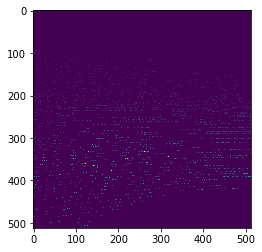

In [274]:
plt.imshow(depth)

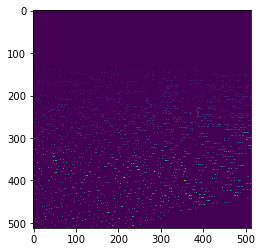

In [275]:
plt.imshow(data_batch['depth_gt'][0,0][0])

In [276]:
data_batch['depth_gt'][0,0][0].max()

tensor(73.0754)

In [277]:
depth.max()

tensor(81.0757)

In [284]:
(depth - data_batch['depth_gt'][0,0][0]).sum()

tensor(-5113.7173)

In [259]:
projected

tensor([[115.8812, 115.8812, 115.8812,  ..., 115.8812, 115.8812, 115.8812],
        [418.4003, 418.4003, 418.4003,  ..., 418.4003, 418.4003, 418.4003],
        [  0.5245,   0.5245,   0.5245,  ...,   0.5245,   0.5245,   0.5245]])

In [239]:
data_batch['intrinsic'][0,0]

tensor([[718.8560,   0.0000, 607.1928],
        [  0.0000, 718.8560, 185.2157],
        [  0.0000,   0.0000,   1.0000]])

In [240]:
torch.inverse(data_batch['intrinsic'][0,0])

tensor([[ 0.0014,  0.0000, -0.8447],
        [ 0.0000,  0.0014, -0.2577],
        [ 0.0000,  0.0000,  1.0000]])

In [236]:
projected

tensor([[-0.2818, -0.2818, -0.2818,  ..., -0.2818, -0.2818, -0.2818],
        [ 0.4469,  0.4469,  0.4469,  ...,  0.4469,  0.4469,  0.4469],
        [ 0.5245,  0.5245,  0.5245,  ...,  0.5245,  0.5245,  0.5245]])

In [206]:
depth - data_batch['depth_gt'][0,0][0]

tensor([[0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245],
        [0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245],
        [0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245],
        ...,
        [0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245],
        [0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245],
        [0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245]])

In [182]:
points3d.shape

torch.Size([3, 262144])

In [178]:
data_batch['intrinsic'][0,0].dtype

torch.float32

In [179]:
uvz.reshape(3,512*512).dtype

torch.float32

In [164]:
torch.inverse(data_batch['intrinsic'][0,0]).dtype

torch.float64